<a href="https://colab.research.google.com/github/gustavomachin/PortfolioOptimization_PyPortfolioOpt/blob/master/OptimizacionCarterasPyPortfolioOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Optimización de carteras usando la biblioteca *PyPortfolioOpt***



PyPortfolioOpt es una biblioteca que implementa los métodos de optimizaicón de carteras. Incluye técnicas clásicas de optimización como la propuesta por Markowitz basada en el rendimiento y riesgo y la asignación de Black-Litterman, así como desarrollos más recientes como Paridad de Riesgo Jerárquica.

Martin, R. A., (2021). PyPortfolioOpt: portfolio optimization in Python. Journal of Open Source Software, 6(61), 3066, https://doi.org/10.21105/joss.03066

## PASO 0: **Instalar e importar las bibliotecas necesarias**

In [3]:
pip install PyPortfolioOpt

In [4]:
pip install yfinance

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [69]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions #para la regularización L2
from pypfopt import plotting
from pypfopt import HRPOpt

## PASO 1: **Obtener los datos de las acciones de forma remota y visualizarlos**

In [7]:
simbolos = ["AAPL","MSFT","TSLA","FB","NVDA"]

In [8]:
df = yf.download(simbolos, start='2021-01-01', rounding=True)
df

[*********************100%***********************]  5 of 5 completed


Adj Close                  ...    Volume                    
                AAPL      FB    MSFT  ...      MSFT      NVDA      TSLA
Date                                  ...                              
2021-01-04    128.62  268.94  215.88  ...  37130100  56064000  48638200
2021-01-05    130.21  270.97  216.09  ...  23823000  32276000  32245200
2021-01-06    125.82  263.31  210.49  ...  35930700  58042400  44700000
2021-01-07    130.12  268.74  216.48  ...  27694500  46148000  51498900
2021-01-08    131.24  267.57  217.79  ...  22956200  29252800  75055500
...              ...     ...     ...  ...       ...       ...       ...
2022-01-19    166.23  319.59  303.33  ...  45933900  48831500  25147500
2022-01-20    164.51  316.56  301.60  ...  35380700  43518100  23496200
2022-01-21    162.41  303.17  296.03  ...  57118300  71743600  34126500
2022-01-24    161.62  308.71  296.37  ...  85731500  91398200  50521900
2022-01-25    158.14  300.35  287.49  ...  27512130  36200118  14986761

[268 rows x 30 columns]

In [9]:
precios = df['Adj Close']
precios

,AAPL,FB,MSFT,NVDA,TSLA
Date,,,,,
2021-01-04,128.62,268.94,215.88,131.02,729.77
2021-01-05,130.21,270.97,216.09,133.93,735.11
2021-01-06,125.82,263.31,210.49,126.03,755.98
2021-01-07,130.12,268.74,216.48,133.32,816.04
2021-01-08,131.24,267.57,217.79,132.65,880.02
...,...,...,...,...,...
2022-01-19,166.23,319.59,303.33,250.67,995.65
2022-01-20,164.51,316.56,301.60,241.50,996.27
2022-01-21,162.41,303.17,296.03,233.74,943.90


In [10]:
rendimientos = precios.pct_change()[1:]
rendimientos

,AAPL,FB,MSFT,NVDA,TSLA
Date,,,,,
2021-01-05,0.012362,0.007548,0.000973,0.022210,0.007317
2021-01-06,-0.033715,-0.028269,-0.025915,-0.058986,0.028390
2021-01-07,0.034176,0.020622,0.028457,0.057843,0.079447
2021-01-08,0.008607,-0.004354,0.006051,-0.005026,0.078403
2021-01-11,-0.023240,-0.040102,-0.009688,0.026008,-0.078214
...,...,...,...,...,...
2022-01-19,-0.021025,0.004526,0.002247,-0.032274,-0.033828
2022-01-20,-0.010347,-0.009481,-0.005703,-0.036582,0.000623
2022-01-21,-0.012765,-0.042298,-0.018468,-0.032133,-0.052566


## PASO 2: **Calcular Riesgo y rendimiento**

### **2.1. Rendimientos esperados**

Los modelos de optimización requieren conocer previamente los rendimientos esperados. En la práctica, estos se calculan en función de datos históricos. 

Usamos función `mean` que vienen en la biblioteca `numpy`

In [11]:
rendEsp = rendimientos.mean()
print(rendEsp)
type(rendEsp)

AAPL    0.000898
FB      0.000592
MSFT    0.001167
NVDA    0.002365
TSLA    0.001435
dtype: float64


pandas.core.series.Series

El módulo `expected_returns` de la biblioteca` PyPortfolioOpt` proporciona las funciones para estimar los rendimientos esperados de las acciones.

Todas las funciones internamente transforman los precios de las acciones en rendimientos porcentuales antes de calcular sus respectivas estimaciones de rendimientos esperados.

Los métodos disponibles para estimar el rendimiento esperado son:

* Renidmiento histórico medio.
* Rendimiento histórico medio ponderado exponencialmente.
* CAPM.

Por defecto, la salida de estos métodos son rendimientos esperados anuales.

In [12]:
#Renidmiento histórico medio.
rendEsp1 = expected_returns.mean_historical_return(precios, returns_data=False, compounding=True, frequency=252, log_returns=False)
rendEsp1

AAPL    0.215324
FB      0.109883
MSFT    0.310452
NVDA    0.635705
TSLA    0.228472
dtype: float64

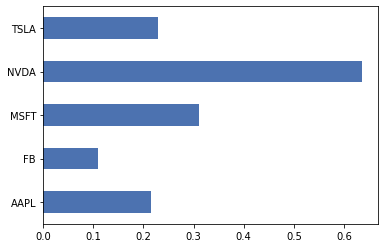

In [13]:
rendEsp1.plot(kind = "barh")

In [14]:
#Rendimiento histórico medio ponderado exponencialmente.
rendEsp2 = expected_returns.ema_historical_return(precios, returns_data=False, compounding=True, span=500, frequency=252, log_returns=False)
rendEsp2

AAPL    0.246520
FB      0.020649
MSFT    0.200765
NVDA    0.561906
TSLA    0.463876
Name: 2022-01-25 00:00:00, dtype: float64

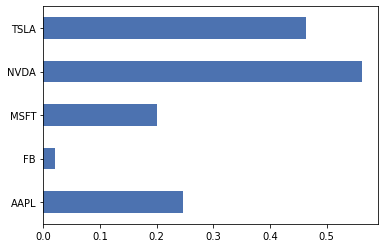

In [15]:
rendEsp2.plot(kind = "barh")

In [16]:
#CAPM.
rendEsp3 = expected_returns.capm_return(precios, market_prices=None, returns_data=False, risk_free_rate=0.02, compounding=True, frequency=252, log_returns=False)
rendEsp3

AAPL    0.240674
FB      0.250635
MSFT    0.210227
NVDA    0.441949
TSLA    0.520139
Name: mkt, dtype: float64

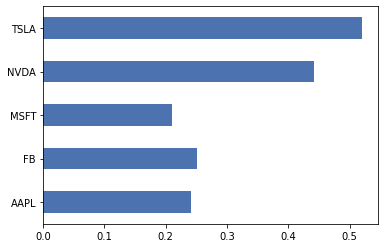

In [17]:
rendEsp3.plot(kind = "barh")

### **2.2. Riesgos**

Usamos función `cov` que vienen en la biblioteca `numpy`

In [18]:
matrizCov = rendimientos.cov()
print(matrizCov)
type(matrizCov)

          AAPL        FB      MSFT      NVDA      TSLA
AAPL  0.000250  0.000152  0.000148  0.000249  0.000271
FB    0.000152  0.000357  0.000139  0.000254  0.000217
MSFT  0.000148  0.000139  0.000188  0.000242  0.000206
NVDA  0.000249  0.000254  0.000242  0.000830  0.000471
TSLA  0.000271  0.000217  0.000206  0.000471  0.001260


pandas.core.frame.DataFrame

El módulo `risk_models` de la `bibliotecaPyPortfolioOpt` proporciona las funciones para estimar el riesgo de las acciones. El método más usado es el que estima la matriz de varianzas y covarianzas en función de los datos históricos. Esta matriz es una representación del riesgo de las acciones individuales (diagonal) y de la covariación entre acciones.


In [19]:
matrizCov1 = risk_models.sample_cov(precios)
matrizCov1

,AAPL,FB,MSFT,NVDA,TSLA
AAPL,0.062888,0.038370,0.037209,0.062872,0.068368
FB,0.038370,0.089951,0.034973,0.063983,0.054604
MSFT,0.037209,0.034973,0.047403,0.060971,0.051938
NVDA,0.062872,0.063983,0.060971,0.209061,0.118816
TSLA,0.068368,0.054604,0.051938,0.118816,0.317541


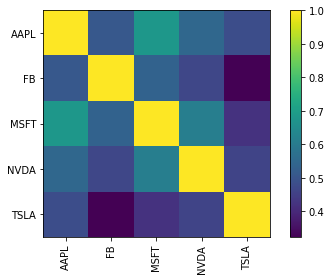

In [20]:
plotting.plot_covariance(matrizCov1, plot_correlation=True, show_tickers=True)

En la práctica contiene errores de especificación y falta de robustez. Esto es particularmente problemático en la optimización a través del método Rendimiento - Riesgo, porque el optimizador puede otorgar mayor credibilidad a los valores erróneos. Por lo tanto, se sugiere el estimador de contracción implementado en la biblioteca `bibliotecaPyPortfolioOpt`

Se utilizará la estimación de covarianza de Ledoit-Wolf.
http://www.ledoit.net/honey.pdf

In [21]:
matrizCov2 = risk_models.CovarianceShrinkage(precios).ledoit_wolf()
matrizCov2

,AAPL,FB,MSFT,NVDA,TSLA
AAPL,0.065844,0.036741,0.035629,0.060204,0.065466
FB,0.036741,0.091759,0.033488,0.061267,0.052286
MSFT,0.035629,0.033488,0.051017,0.058383,0.049734
NVDA,0.060204,0.061267,0.058383,0.205813,0.113772
TSLA,0.065466,0.052286,0.049734,0.113772,0.309688


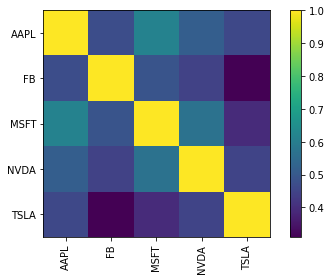

In [22]:
plotting.plot_covariance(matrizCov2, plot_correlation=True, show_tickers=True)


## PASO 3: **Determinar las participaciones**

Se determinan las participaciones de cada acción en la cartera usando el método de rendimiento - riesgo. Además, en todo problema de optimización existe un objetivo a optimizar y las restricciones; por ejemplo el objetivo puede ser minimizar el riesgo y la restricción un nivel de rendimiento. 

### **3.1. Armar la frotnera eficiente**

La función `EfficientFrontier` permite definir la frontera eficiente, es decir, el conjunto de carteras que maximiza el rendimiento para determinados niveles de rendimiento o minimiza el riesgo para determinados niveles de rendimiento.

El objeto creado con la función contiene varios métodos que corresponden a las diferentes funciones objetivo a optimizar:
* `min_volatility()` : optimiza para obtener la mínima volatilidad, también conocida como cartera de mínima varianza o riesgo.
* `max_sharpe()` : optimiza para obtener el máximo ratio de Sharpe, también conocida como cartera de tangencia.
* `max_quadratic_utility()` : maximiza la utilidad cuadrática, dada una adversión al riesgo.
* `efficient_risk()` : maximiza el rendimiento dado un nivel de riesgo.
* `efficient_return()` : minimiza el riesgo dado un nivel de rendimiento.

In [23]:
fe = EfficientFrontier(rendEsp1, matrizCov2, weight_bounds=(0, 1))

### **3.2. Definir un objetivo de optimización**

**3.2.1. Mínimo riesgo**

Devuelve los pesos de las acciones para la cartera que minimiza la volatilidad.

In [24]:
varianza_minima = fe.min_volatility()
pesos = fe.clean_weights() # redondea los pesos y hace cero los valores muy cercanos a cero.
pesos

OrderedDict([('AAPL', 0.27005),
             ('FB', 0.16484),
             ('MSFT', 0.56511),
             ('NVDA', 0.0),
             ('TSLA', 0.0)])

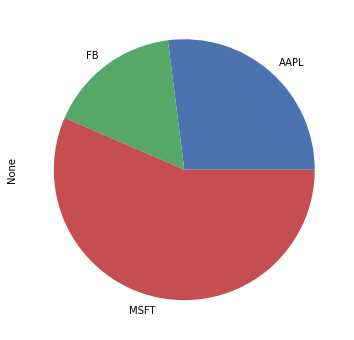

In [25]:
pd.Series(pesos).plot(kind="pie", figsize=(6,6))

In [26]:
fe.portfolio_performance(verbose=True) #calcula el rendimiento esperado, volatilidad y ratio de Sharpe para la cartera optimizada.

Expected annual return: 25.2%
Annual volatility: 21.0%
Sharpe Ratio: 1.10


(0.2517006765289068, 0.20969509767041333, 1.1049408360184014)

**3.2.2. Máximo ratio de Sharpe**

Devuelve los pesos de las acciones que maximizan el ratio de Sharpe. Este método intenta determinar los pesos o las participaciones de las acciones que maximize el rendimiento por unidad de riesgo. Esta cartera es conocida como la cartera de tangencia, es la cartera donde la linea de mercado de capitales (capital market line) es tangente a la frontera eficiente.



In [27]:
fe = EfficientFrontier(rendEsp1, matrizCov2, weight_bounds=(0, 1)) # siempre se debe crear una nieva frontera eficiente
max_sharpe = fe.max_sharpe(risk_free_rate=0.02)
pesos = fe.clean_weights() # redondea los pesos y hace cero los valores muy cercanos a cero.
pesos

OrderedDict([('AAPL', 0.0),
             ('FB', 0.0),
             ('MSFT', 0.62247),
             ('NVDA', 0.37753),
             ('TSLA', 0.0)])

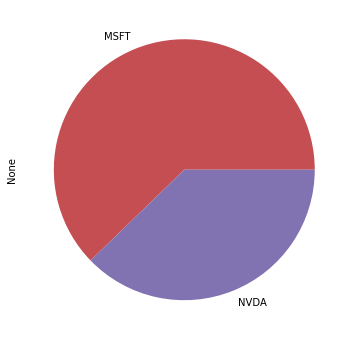

In [28]:
pd.Series(pesos).plot(kind="pie", figsize=(6,6), )

In [29]:
fe.portfolio_performance(verbose=True)

Expected annual return: 43.3%
Annual volatility: 27.7%
Sharpe Ratio: 1.49


(0.43324328929678524, 0.27666160528288747, 1.4936777688188518)

**3.2.3. Máximo rendimiento dado un nivel de riesgo**

Determina las participaciones que maximizan el rendimiento para un nivel dado de riesgo. Es uno de los supuestos básicos de la teoría de Markowitz (Insaciabilidad).  

In [30]:
fe = EfficientFrontier(rendEsp1, matrizCov2)
fe.efficient_risk(target_volatility= 0.25)
pesos = fe.clean_weights() 
pesos


OrderedDict([('AAPL', 0.0),
             ('FB', 0.0),
             ('MSFT', 0.76147),
             ('NVDA', 0.23853),
             ('TSLA', 0.0)])

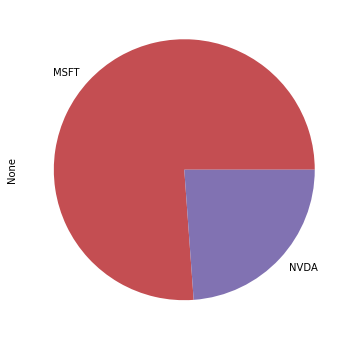

In [31]:
pd.Series(pesos).plot(kind="pie", figsize=(6,6))

In [32]:
fe.portfolio_performance(verbose=True)

Expected annual return: 38.8%
Annual volatility: 25.0%
Sharpe Ratio: 1.47


(0.3880331843378536, 0.2500000001894728, 1.4721327362356977)

**3.2.3. Mínimo riesgo dado un nivel de rendimiento**

Determina las participaciones que minimizan el riesgo para un nivel dado de rendimiento. Es uno de los supuestos básicos de la teoría de Markowitz (Aversión al riesgo). 

In [33]:
fe = EfficientFrontier(rendEsp1, matrizCov2)
fe.efficient_return(target_return=0.35)
pesos = fe.clean_weights() 
pesos

OrderedDict([('AAPL', 0.09106),
             ('FB', 0.0),
             ('MSFT', 0.76072),
             ('NVDA', 0.14822),
             ('TSLA', 0.0)])

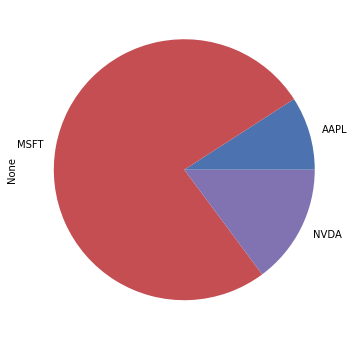

In [34]:
pd.Series(pesos).plot(kind="pie", figsize=(6,6))

In [35]:
fe.portfolio_performance(verbose=True)

Expected annual return: 35.0%
Annual volatility: 23.3%
Sharpe Ratio: 1.42


(0.3499999999999999, 0.23306271405141282, 1.4159279031102463)

**3.2.4. Paridad de riesgo jerárquica**

La paridad de riesgo jerárquica o HRP por sus siglas en inglés es un metodo de optimización inspirado en el Aprendizaje Automático (Machine Learning). La idea es que al examinar la estructura jerárquica del mercado, es posible diversificarnos mejor.

A continuación se usará para encontrar la cartera de mínimo riesgo. Cabe mencionar que no es posible agregar objetivos ni restricciones a este optimizador.

In [70]:
hrp = HRPOpt(rendimientos)
hrp.optimize()
pesos = hrp.clean_weights()
pesos

OrderedDict([('AAPL', 0.22487),
             ('FB', 0.28328),
             ('MSFT', 0.29833),
             ('NVDA', 0.11328),
             ('TSLA', 0.08024)])

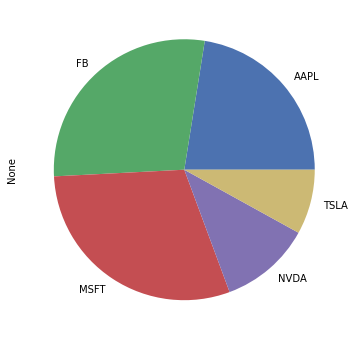

In [71]:
pd.Series(pesos).plot(kind="pie", figsize=(6,6))

In [72]:
hrp.portfolio_performance(verbose=True)

Expected annual return: 27.7%
Annual volatility: 23.7%
Sharpe Ratio: 1.09


(0.277434935179782, 0.23698887317488498, 1.0862743542807975)

Se grafica un dendrograma (diagrama de árbol) basado en la estructura jerárquica de los rendimientos de los activos.

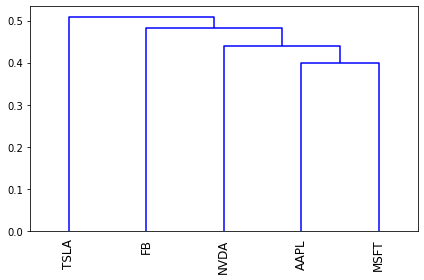

In [73]:
plotting.plot_dendrogram(hrp)

### **3.3. Agregar objetivos y restricciones**

**3.3.1. Regularización L2.** 

Este es un concepto del Aprendizaje Automático , sin embargo, acá se usa para incrementar el número de pesos o participaciones distintas de cero y tener una cartera más diversificada.

Usemos como ejemplo la maximización del rendimiento dado una volatilidad del 25%. (participaciones obtenidas: 75% microfost, 25% nvidia)

Si bien parece que esta cartera cumple con nuestros objetivos, a la mayoría de los tickers se les ha asignado peso cero. En efecto, el optimizador se está "sobreajustando" a los datos que ha proporcionado: es más probable que obtenga mejores resultados al aplicar cierto nivel de diversificación. Una forma de lograr esta diversificación es mediante la regularización L2, esencialmente, agregando una penalización a la función objetivo cuando hay ponderaciones (pesos) cercanas a cero.

In [36]:
fe = EfficientFrontier(rendEsp1, matrizCov2)
fe.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamma es un parámetro de ajuste, se incrementa en la medida que querramos más pesos distintos de cero (mayor diversificación).
fe.efficient_risk(target_volatility= 0.25)
pesos = fe.clean_weights() 
pesos

OrderedDict([('AAPL', 0.18031),
             ('FB', 0.0),
             ('MSFT', 0.55296),
             ('NVDA', 0.26673),
             ('TSLA', 0.0)])

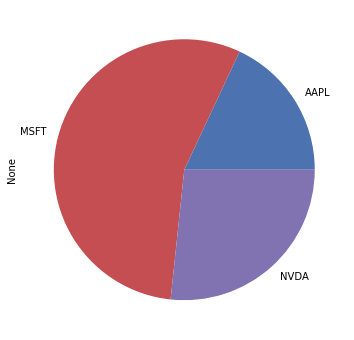

In [37]:
pd.Series(pesos).plot(kind="pie", figsize=(6,6))

In [38]:
fe.portfolio_performance(verbose=True)

Expected annual return: 38.0%
Annual volatility: 25.0%
Sharpe Ratio: 1.44


(0.3800538272036079, 0.2500000000843682, 1.4402153083283982)

**3.3.2. Posiciones Largas / Posiciones Cortas** 

De forma predeterminada, todos los métodos de optimización de riesgo - rendimiento en `PyPortfolioOpt` toman posiciones largas, sin embargo se pueden configurar para permitir posiciones cortas cambiando el parámetro `weight_bounds`. Este parámetro representa el mínimo y máximo peso que puede tomar cada acción en la cartera.


*   Posición larga : (0,1) por defecto.
*   Posición corta : (-1,1).

Usando el ejemplo anterior:


In [39]:
fe = EfficientFrontier(rendEsp1, matrizCov2, weight_bounds=(-1,1))
fe.add_objective(objective_functions.L2_reg, gamma=0.1)  
fe.efficient_risk(target_volatility= 0.25)
pesos = fe.clean_weights() 
pesos

OrderedDict([('AAPL', 0.21612),
             ('FB', -0.01448),
             ('MSFT', 0.57642),
             ('NVDA', 0.28164),
             ('TSLA', -0.0597)])

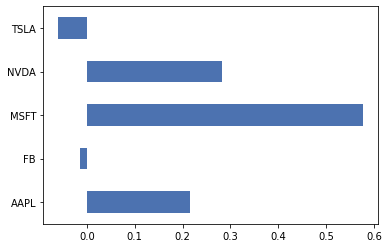

In [40]:
pd.Series(pesos).plot(kind="barh")

**3.3.3. Neutralidad de mercado** 

Para los objetivos `efficient_risk()` y `efficient_return()`, `PyPortfolioOpt` ofrece una opción para formar una cartera de mercado neutral (es decir, los pesos suman cero). Esto no es posible para la cartera de máximo ratio de Sharpe (cartera de tangencia) y la cartera de mínimo riesgo, porque en esos casos no son invariantes con respecto al apalancamiento. La neutralidad del mercado requiere ponderaciones negativas, es decir, posiciones cortas.

In [41]:
fe = EfficientFrontier(rendEsp1, matrizCov2, weight_bounds=(-1,1))
fe.add_objective(objective_functions.L2_reg, gamma=0.1)  
fe.efficient_risk(target_volatility= 0.25, market_neutral = True) #por defecto el parámetro es False 
pesos = fe.clean_weights() 
pesos

OrderedDict([('AAPL', -0.19625),
             ('FB', -0.45685),
             ('MSFT', 0.12458),
             ('NVDA', 0.65183),
             ('TSLA', -0.12332)])

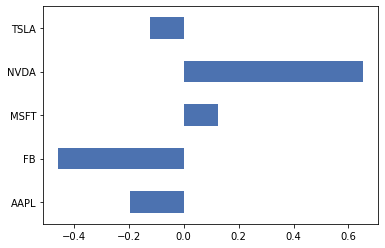

In [42]:
pd.Series(pesos).plot(kind="barh")

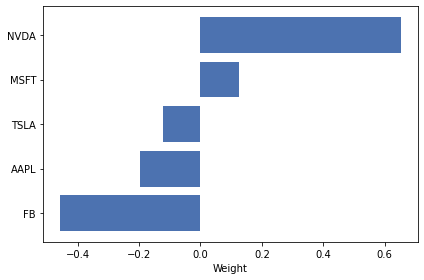

In [43]:
plotting.plot_weights(pesos)

**3.3.4. Participaciones en la cartera** 


En el caso de la máxima participación en la cartera, se busca que cada activo no supere cierta participación dentro de la cartera, para lo cual se modifica el parámetro `weight_bounds`. Por ejemplo, no se podría invertir más del 40% en cada acción:

In [44]:
fe = EfficientFrontier(rendEsp1, matrizCov2, weight_bounds=(0, 0.4))
fe.max_sharpe()

OrderedDict([('AAPL', 0.2),
             ('FB', 0.0),
             ('MSFT', 0.4),
             ('NVDA', 0.4),
             ('TSLA', 0.0)])

También es posible fijar las participaciones que tendrán ciertas acciones en la cartera usando el método `add_constraint()` y funciones lamda personalizadas. Por ejemplo, que la participación de NVDA en la cartera sea del 20%, la de TSLA sea mayor o igual al 5% y que MSFT no supere el 40%:

In [45]:
fe = EfficientFrontier(rendEsp1, matrizCov2)

NVDA_pos = fe.tickers.index('NVDA')
fe.add_constraint(lambda w: w[NVDA_pos] == 0.20)

TSLA_pos = fe.tickers.index('TSLA')
fe.add_constraint(lambda w: w[TSLA_pos] >= 0.05)

fe.add_constraint(lambda w: w[2] <= 0.4) #pasamos directamente la posición, MSFT tiene la posición 2 en el diccionario.

fe.max_sharpe()


OrderedDict([('AAPL', 0.3499999999999998),
             ('FB', 0.0),
             ('MSFT', 0.4),
             ('NVDA', 0.2),
             ('TSLA', 0.05)])

## PASO 4: **Graficar carteras**

Se graficará la frontera eficiente usando el módulo `plotting` y simulación montecarlo para generar carteras de manera aleatoria. 

En el siguiente ejemplo se graficará la frontera eficiente simulando 100.000 carteras:

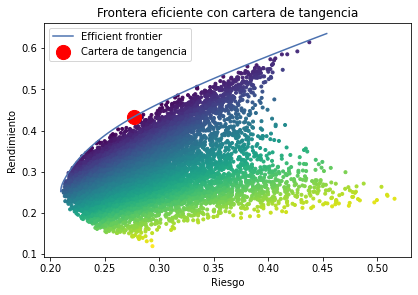

In [75]:
fe = EfficientFrontier(rendEsp1, matrizCov2)

fig, ax = plt.subplots()
# Grafica la frotnera eficiente
plotting.plot_efficient_frontier(fe, show_assets=False)

# Genera y grafica las carteras aleatorias
n_carteras = 10000
w = np.random.dirichlet(np.ones(len(precios.columns)), n_carteras)
rendimiento = w.dot(rendEsp1)
riesgo = np.sqrt(np.diag(w @ matrizCov2 @ w.T))
sharpes = rendimiento / riesgo
ax.scatter(riesgo, rendimiento, marker=".", c=sharpes, cmap="viridis_r")

# Encuentra y grafica la cartera de tangencia
fe = EfficientFrontier(rendEsp1, matrizCov2)
fe.max_sharpe()
rend_tangente, riesgo_tangente, _ = fe.portfolio_performance()
ax.scatter(riesgo_tangente, rend_tangente, marker="o", s=200, c="r", label="Cartera de tangencia")

ax.set_title("Frontera eficiente con cartera de tangencia")
ax.legend()
plt.ylabel("Rendimiento")
plt.xlabel("Riesgo")
plt.show()
